# Learning Diffusion

- Loading dataset
- Add noise
- Predict


## References

[Guide for diffusion model](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb#scrollTo=wmUQLdIYe0cn)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np

In [3]:
# Load the MNIST dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.70MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 278kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.90MB/s]


In [7]:
# Create train loader
train_loader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)

Shape of x: torch.Size([8, 1, 28, 28])
Labels: tensor([0, 5, 4, 4, 4, 3, 4, 1])


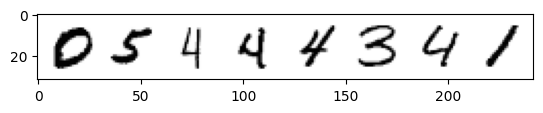

In [9]:
# Print sample of the dataset

# Get a batch of data
x,y = next(iter(train_loader))
print(f"Shape of x: {x.shape}")
print(f"Labels: {y}")

plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [10]:
def add_noise(x, amount):
    """
    Add random noise to the input tensor.
    """
    # Get numbers between 0 and 1
    noise = torch.randn_like(x)
    # Calculate the amount of noise to add
    amount = amount.view(-1, 1, 1, 1)
    # Scale the noise
    return x*(1-amount) + noise*amount

In [ ]:
# Plotting normal data vs noisy data
from matplotlib.pyplot import subplots
def plot_data(x, amount):

    x_noise = add_noise(x,amount)

    fig,ax = subplots(1,2, figsize=(10,5))
    ax[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
    ax[0].set_title("Original Data")
    
    ax[1].imshow(torchvision.utils.make_grid(x_noise)[0], cmap="Greys")
    ax[1].set_title("Noisy Data")
    plt.show()

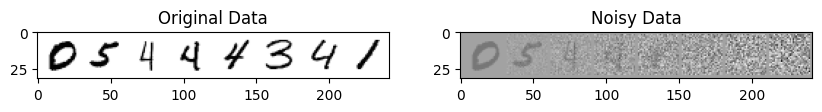

In [13]:
# Setting the amount of noise
# Range from 0 to 1 with the same number of samples as x
amount = torch.linspace(0,1, x.shape[0])
# Plot the normal data and the noisy data
plot_data(x,y, amount)

In [18]:
# Creating a UNET model for denoising
class BasicUNET(nn.Module):
    """ A minimal UNET model for denoising. """
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # Through the layer and the activation function
            if i < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for i, l in enumerate(self.up_layers):
            if i > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(l(x)) # Through the layer and the activation function
            
        return x

In [19]:
net = BasicUNET()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [20]:
sum([p.numel() for p in net.parameters()]) # Number of parameters in the model

309057

In [41]:
import tqdm
# Training the model
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a new dataset with noisy data
train_dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

net = BasicUNET()
net.to(device)

losses = []

def train_model(model, dataloader, LR, losses, DMODEL=False):
    """ Train the model on the dataset. """
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    # Training loop
    for epoch in tqdm.tqdm(range(EPOCHS)):
        print(f"Epoch {epoch+1}/{EPOCHS}")
        # Loop through the dataset
        for x, y in dataloader:
            
            # Move data to the device (Use GPU on data if available)
            x = x.to(device)
            y = y.to(device)

            # Add noise to the data
            amount = torch.rand(x.shape[0], 1, 1, 1).to(device)
            x_noise = add_noise(x, amount)

            # Forward pass
            if DMODEL:
                pred = model(x_noise, 0).sample
            else:
                pred = model(x_noise)
            loss = loss_fn(pred, x)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        # Print the average loss for the epoch, excluding the first 10 batches
        average_loss = sum(losses[-len(dataloader):]) / len(dataloader)
        print(f"Finished epoch {epoch} with average loss: {average_loss}")
        # Plot the loss
        plt.plot(losses)
        plt.title("Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()
        # Save the model
        torch.save(model.state_dict(), "model.pth")
    return model, losses, x, x_noise, pred

In [37]:
# Plot normal, noise and predictions
def plot_predictions(x, x_noise, pred):
    fig,ax = subplots(1,3, figsize=(10,5))
    ax[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
    ax[0].set_title("Original Data")
    
    ax[1].imshow(torchvision.utils.make_grid(x_noise)[0], cmap="Greys")
    ax[1].set_title("Noisy Data")

    ax[2].imshow(torchvision.utils.make_grid(pred)[0], cmap="Greys")
    ax[2].set_title("Predictions")
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Finished epoch 0 with average loss: 0.03706727215627045


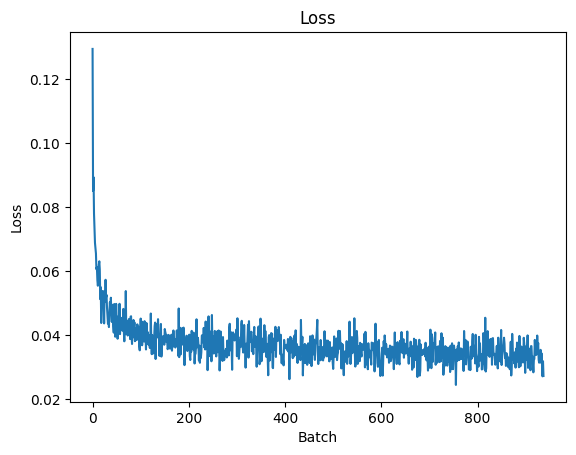

 20%|██        | 1/5 [01:48<07:14, 108.51s/it]

Epoch 2/5
Finished epoch 1 with average loss: 0.032672557848761836


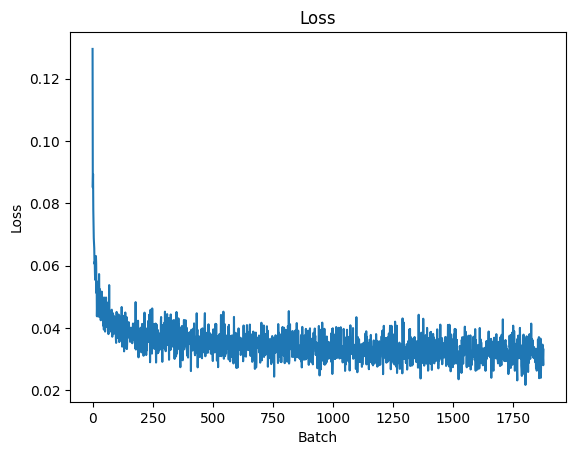

 40%|████      | 2/5 [03:30<05:13, 104.51s/it]

Epoch 3/5
Finished epoch 2 with average loss: 0.03179477623054214


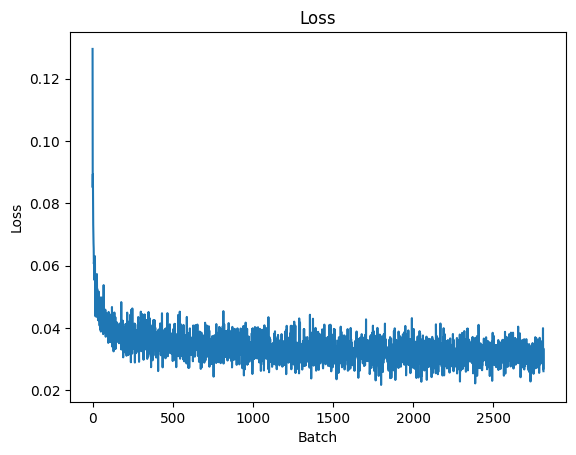

 60%|██████    | 3/5 [05:10<03:25, 102.52s/it]

Epoch 4/5
Finished epoch 3 with average loss: 0.03142130121326586


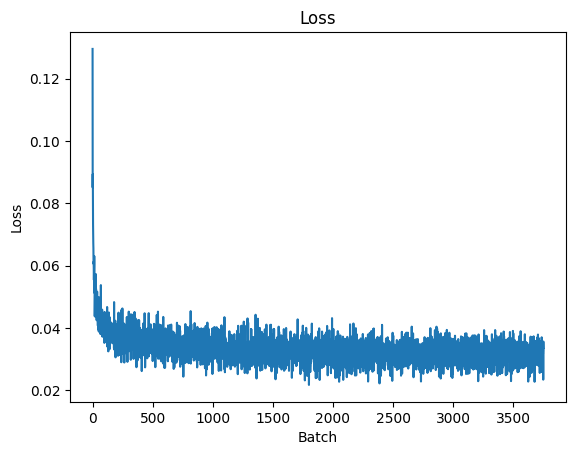

 80%|████████  | 4/5 [06:51<01:41, 101.84s/it]

Epoch 5/5
Finished epoch 4 with average loss: 0.03126118565871835


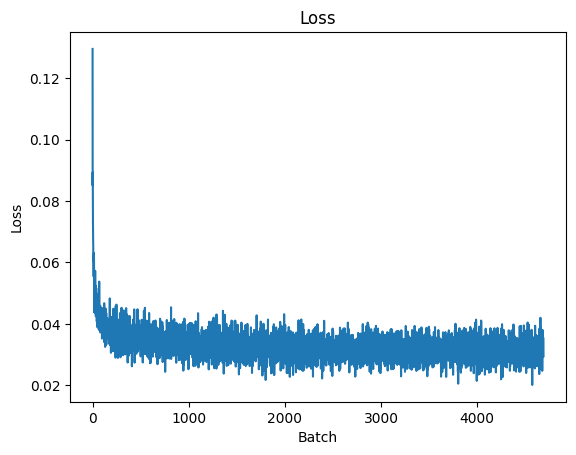

100%|██████████| 5/5 [08:41<00:00, 104.39s/it]


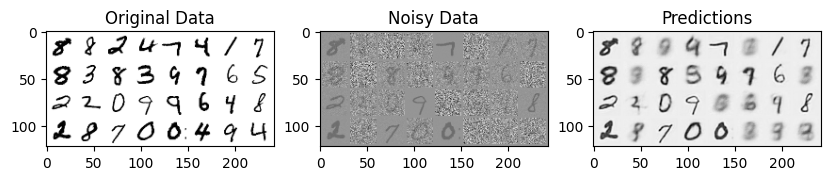

In [38]:
model, losses, x, x_noise, pred = train_model(net, train_dataloader, LR, losses)
plot_predictions(x, x_noise, pred)

In [39]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(model)

# Print the number of parameters in the model
sum([p.numel() for p in model.parameters()])

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

1707009

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Finished epoch 0 with average loss: 0.0349926715696862


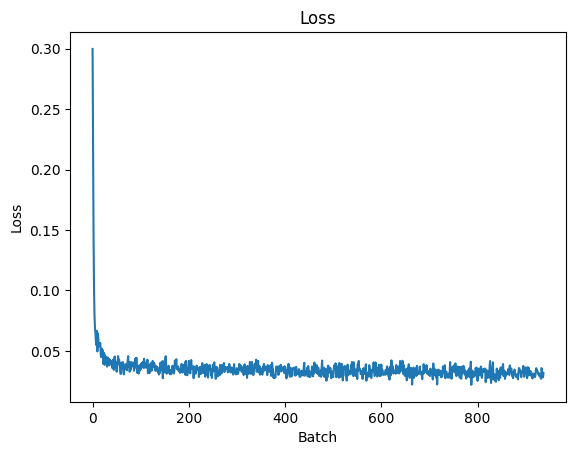

 20%|██        | 1/5 [23:40<1:34:41, 1420.39s/it]

Epoch 2/5
Finished epoch 1 with average loss: 0.031187045022543432


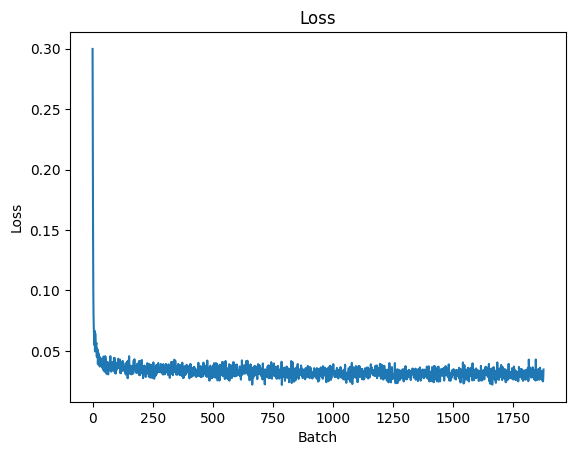

 40%|████      | 2/5 [46:17<1:09:10, 1383.38s/it]

Epoch 3/5
Finished epoch 2 with average loss: 0.03040241022536686


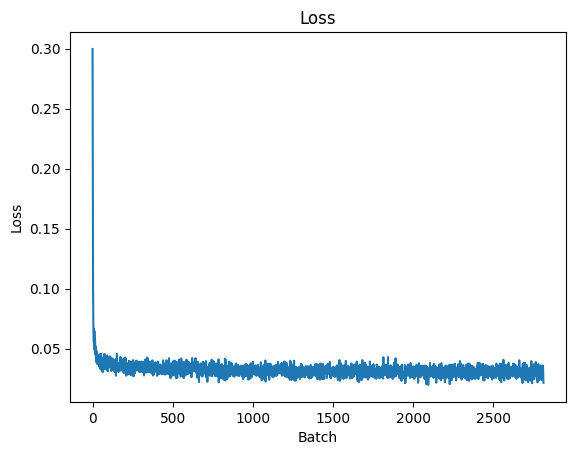

 60%|██████    | 3/5 [1:08:18<45:09, 1354.86s/it]

Epoch 4/5
Finished epoch 3 with average loss: 0.030026295607579925


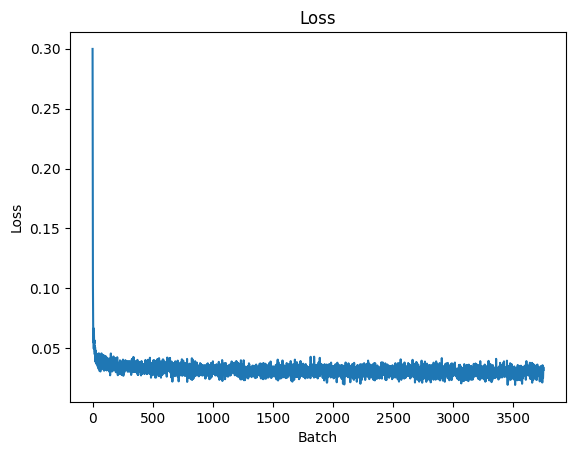

 80%|████████  | 4/5 [1:30:18<22:21, 1341.02s/it]

Epoch 5/5
Finished epoch 4 with average loss: 0.029574925830559946


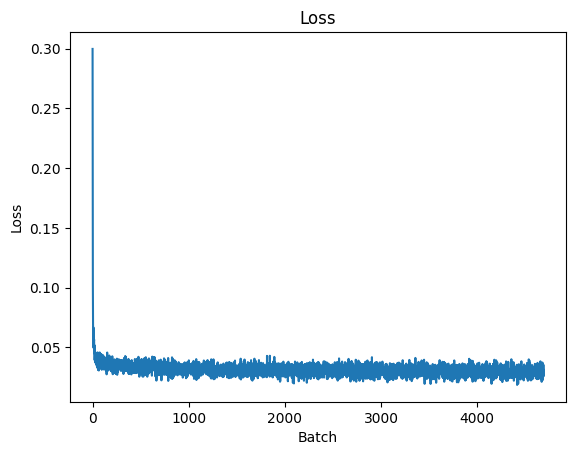

100%|██████████| 5/5 [1:52:19<00:00, 1347.87s/it]


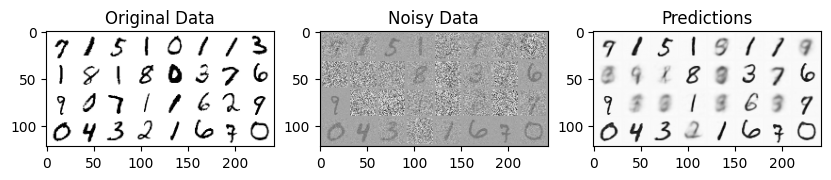

In [43]:
# Train the UNET2dModel
mode, losses, x, x_noise, pred = train_model(model, train_dataloader, LR, losses, DMODEL=True)
plot_predictions(x, x_noise, pred)

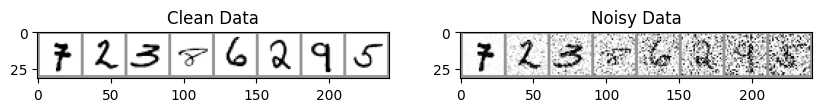

In [64]:
# Add noise scheduler
from diffusers import DDPMScheduler
scheduler = DDPMScheduler(
    beta_start=0.01,       # Starting beta value
    beta_end=0.04,           # Ending beta value
    beta_schedule="linear",   # Linear schedule
)
scheduler.config.num_train_timesteps = 1000 # Number of timesteps

# Add noise to new sample
xb, yb = next(iter(train_loader))
xb = xb.to(device)[:8]
xb = xb * 2 - 1 # Scale to [-1, 1]

fig, axe = subplots(1,2, figsize=(10,5))

axe[0].imshow(torchvision.utils.make_grid(xb)[0], cmap="Greys")
axe[0].set_title("Clean Data")


timesteps = torch.linspace(0, 99, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = scheduler.add_noise(xb, noise, timesteps)
# Plot the noisy data with clipping (means to scale values to 0-1)
axe[1].imshow(torchvision.utils.make_grid(noisy_xb)[:8][0].detach().cpu().clip(-1,1), cmap="Greys")
axe[1].set_title("Noisy Data")
plt.show()

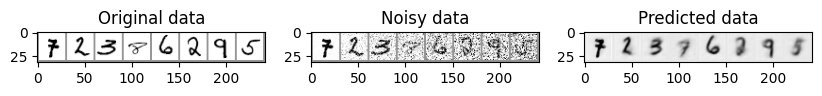

In [65]:
from torch.nn import MSELoss
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = scheduler.add_noise(xb, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = MSELoss()
computed_loss = loss(model_prediction, noise) # noise as the target
fig, ax = subplots(1,3, figsize=(10,5))
ax[0].imshow(torchvision.utils.make_grid(xb)[0].detach().cpu().clip(-1,1), cmap="Greys")
ax[0].set_title('Original data')

ax[1].imshow(torchvision.utils.make_grid(noisy_x)[1].detach().cpu().clip(-1,1), cmap="Greys")
ax[1].set_title('Noisy data')

ax[2].imshow(torchvision.utils.make_grid(model_prediction)[2].detach().cpu().clip(-1,1), cmap="Greys")
ax[2].set_title('Predicted data')
plt.show()